In [37]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="multiprocessing.resource_tracker")

import numpy as np
import matplotlib.pyplot as plt

import nbi

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
print(nbi.__version__)

0.3.1


Let us consider a very simple sine curve model, where $t$ is time, $\omega$ is angular frequency, $A$ is amplitude, and $\phi_0$ is initial phase:<br>
$f(t) = A\cdot\sin(\omega\cdot t+\phi_0$)

Assume parameters from the following uniform distribution:<br>
$\phi_0\in[0,2\pi]$, $A\in[1,5]$, $\omega\in[2\pi,12\pi]$

Also assume Gaussian measurement noise fixed to be $\sigma_0$:<br>
$x_{\rm obs}\sim N(f(t), \sigma=\sigma_0)$

In [3]:
t = np.linspace(0,1,50)
def sine(param):
    phi0, A, omega = param
    return np.sin(omega * t + phi0) * A

In [4]:
# nbi requires prior to be defined with scipy functions

from scipy.stats import uniform, truncnorm
prior = {
    'phi0': uniform(loc=0, scale=np.pi*2),
    'A': uniform(loc=1, scale=4),
    'omega': uniform(loc=2*np.pi, scale=10*np.pi)
}
labels = list(prior.keys())
priors = [prior[k] for k in labels]

# One target: SNPE
Let us first consider inference for one target. Randomly sample an observation from prior space and add noise.

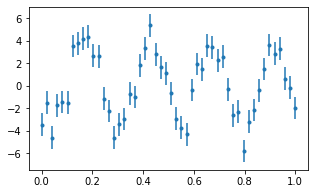

In [5]:
plt.figure(figsize=(5,3))

np.random.seed(0)

# draw random parameter from prior
y_true = [var.rvs(1)[0] for var in priors]

# add fixed gaussian noise of 1
x_err = 1
x_obs = sine(y_true) + np.random.normal(size=50) * x_err
plt.errorbar(t, x_obs, yerr=x_err, fmt='.')

plt.show()

In [8]:
# hyperparameters for the normalizing flow
flow = {
    'n_dims': 3,              # dimension of parameter space
    'flow_hidden': 32,
    'num_cond_inputs': 32,
    'num_blocks': 4
}

# the NBI package provides the "ResNet-GRU" network as the default
# featurizer network for sequential data
featurizer = {
    'type': 'resnet-gru',
    'dim_in': 1,
    'dim_conv_max': 256,
    'depth': 3
}

# initialize NBI engine
engine = nbi.NBI(
    flow=flow,
    featurizer=featurizer,
    simulator=sine,
    priors=priors,
    labels=labels,
    n_jobs=10
)

Generating simulations


128it [00:00, 466.25it/s]


Effective sample size for current/all rounds 0.1/0.1

---------------------- Round: 0 ----------------------


- Val, Loglike in nats: 1.976798: 100%|██████████| 128/128 [00:00<00:00, 188.45it/s]


early stopping, loading state dict from epoch 49
Generating simulations


128it [00:00, 469.72it/s]


Effective sample size for current/all rounds 27.2/27.3


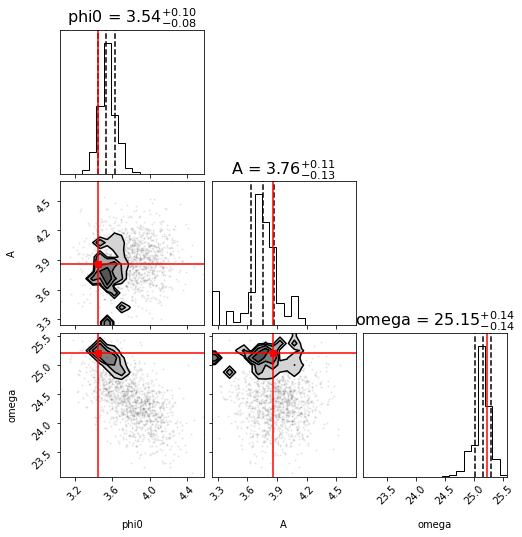


---------------------- Round: 1 ----------------------


- Val, Loglike in nats: -1.784986: 100%|██████████| 128/128 [00:00<00:00, 182.42it/s]


early stopping, loading state dict from epoch 26
Generating simulations


128it [00:00, 476.41it/s]


Effective sample size for current/all rounds 700.2/727.5


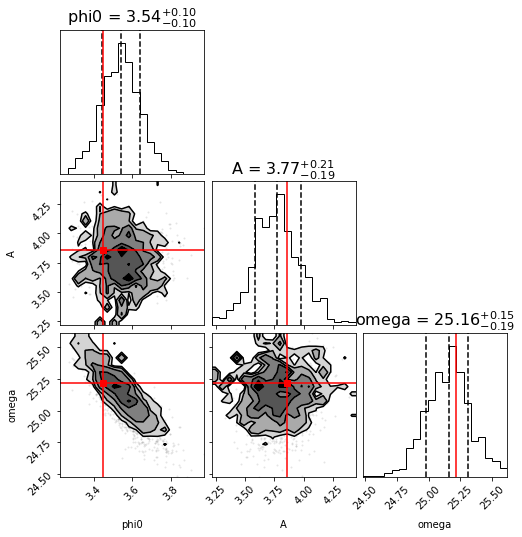


---------------------- Round: 2 ----------------------


- Val, Loglike in nats: -2.765782: 100%|██████████| 128/128 [00:00<00:00, 170.43it/s]


early stopping, loading state dict from epoch 9
Generating simulations


128it [00:00, 465.64it/s]


Effective sample size for current/all rounds 147.1/874.6


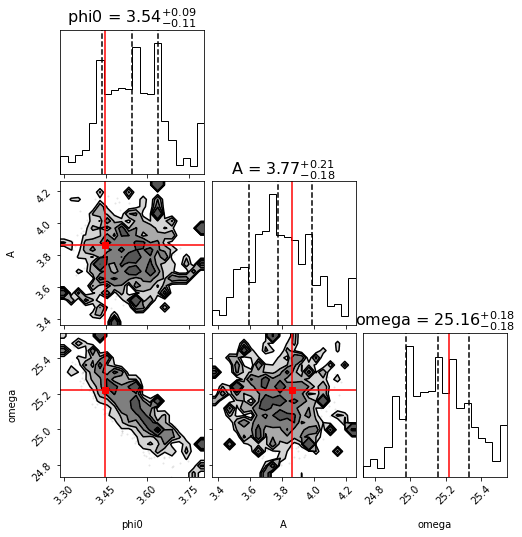

Early stop: Surrogate posterior did not improve for this round
Loaded state from round  1


In [9]:
engine.fit(
    x_obs=x_obs,
    y_true=y_true,
    n_sims=1280,
    n_rounds=5,
    n_epochs=100,
    batch_size=64,
    early_stop_train=True,      # If sampling efficiency is reduced, stop and revert to previous round
    early_stop_patience=5,      # Within a round, wait this many epochs before early stopping
    noise=np.array([1]*50)      # this is used for importance sampling
)

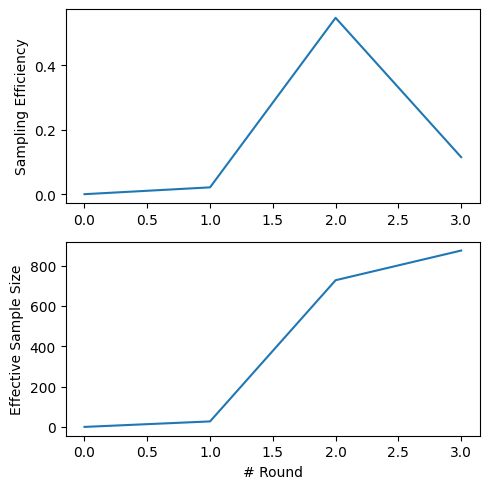

In [20]:
plt.rcParams['figure.dpi']=100
plt.figure(figsize=(5,5))
plt.subplot(211)
plt.plot(np.array(engine.neff)/1280)
plt.ylabel('Sampling Efficiency')
plt.subplot(212)
plt.plot([np.sum(engine.neff[:i+1]) for i in range(4)])
plt.ylabel('Effective Sample Size')
plt.xlabel('# Round')
plt.tight_layout()

As we see, after the 2nd round of training the sampling efficiency is as high as ~50%, meaning the NDE posterior is nearly the true posterior. As expected, the third round of training degraded the result due to the use of NLL loss. Therefore, we revert to the second round. Nevertheless, the third round still contributed 147 effective posterior samples. In practice, we can specify the f_accept_min parameter for a sampling efficiency threshold to terminate training early.

To generate more effective posterior samples, let us draw 10000 more samples from the 2nd round NDE. The corner plot shows the importance reweighted posterior (contour) as well as the unweighted full sample (scatter).

Generating simulations


1000it [00:01, 502.44it/s]


Effective Sample Size = 5532.0
Sampling efficiency = 55.3%


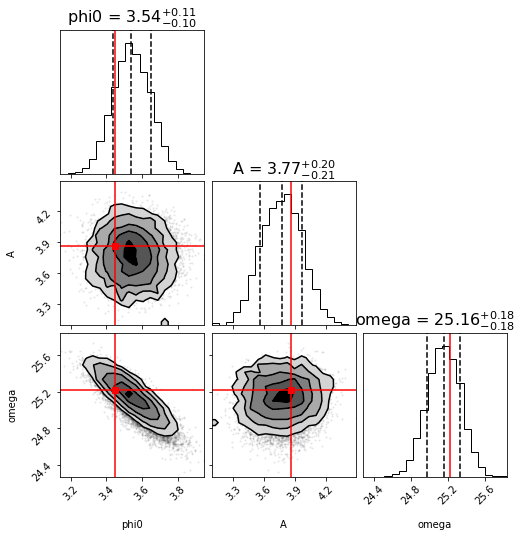

In [10]:
y_pred, weights = engine.predict(x_obs, x_err=np.array([1]*50),y_true=y_true, n_samples=10000, corner_reweight=True)

# Many targets: ANPE
if we care about a large number of different x_obs, then train nbi for only 1 round on more samples generated from the prior space of interest.

In [21]:
# let's say we have a large set of observed sine curves with different noise levels
# instead of initializing the NBI engine with fixed noise, we have provide it with a
# noise function that takes in noise free "x" and returns a noisified x

# the noise function can include any component of the forward model that is cheap
def noise(x, y):
    rand = np.random.normal(0, 1, size=x.shape[0])
    
    # let's say x_err is drawn from [0.1, 2]
    x_err = np.random.uniform() * 1.9 + 0.1
    x_noise = x + rand * x_err
    return x_noise, y

In [29]:
# same hyperparameter as before

flow = {
    'n_dims': 3,
    'flow_hidden': 32,
    'num_cond_inputs': 32,
    'num_blocks': 4
}

featurizer = {
    'type': 'resnet-gru',
    'dim_in': 1,
    'dim_conv_max': 256,
    'depth': 3
}


# initialize NBI engine
engine = nbi.NBI(
    flow=flow,
    featurizer=featurizer,
    simulator=sine,
    priors=priors,
    labels=labels,
    n_jobs=10
)

To compare with SNPE, let us adapt the same number of training samples (2560) that allowed for the ~50% sampling efficiency for previous SNPE example. Presumably, ANPE would not achieve that 50% sampling efficiency seen with SNPE for that particular sine curve, which uses active learning. Of course, the benifit is that we may do inference on any observations within the prior

In [30]:
engine.fit(
    n_sims=2560,
    n_rounds=1,
    n_epochs=100,
    early_stop_patience=5,
    lr=0.001,
    min_lr=0.001/200,
    noise=noise
)

Generating simulations


256it [00:00, 510.05it/s]



---------------------- Round: 0 ----------------------


- Val, Loglike in nats: 2.249238: 100%|██████████| 256/256 [00:00<00:00, 294.17it/s]


early stopping, loading state dict from epoch 46


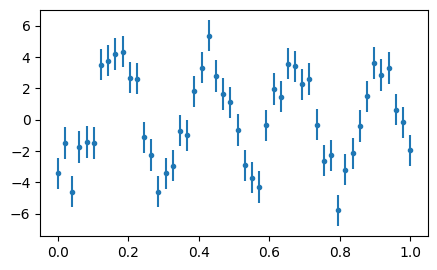

In [31]:
# same example observation as SNPE

plt.figure(figsize=(5,3))

np.random.seed(0)

# draw random parameter from prior
y_true = [var.rvs(1)[0] for var in priors]

# add fixed gaussian noise of 1
x_err = 1
x_obs = sine(y_true) + np.random.normal(size=50) * x_err
plt.errorbar(t, x_obs, yerr=x_err, fmt='.')

plt.show()

Generating simulations


1000it [00:01, 525.48it/s]


Effective Sample Size = 671.9
Sampling efficiency = 6.7%


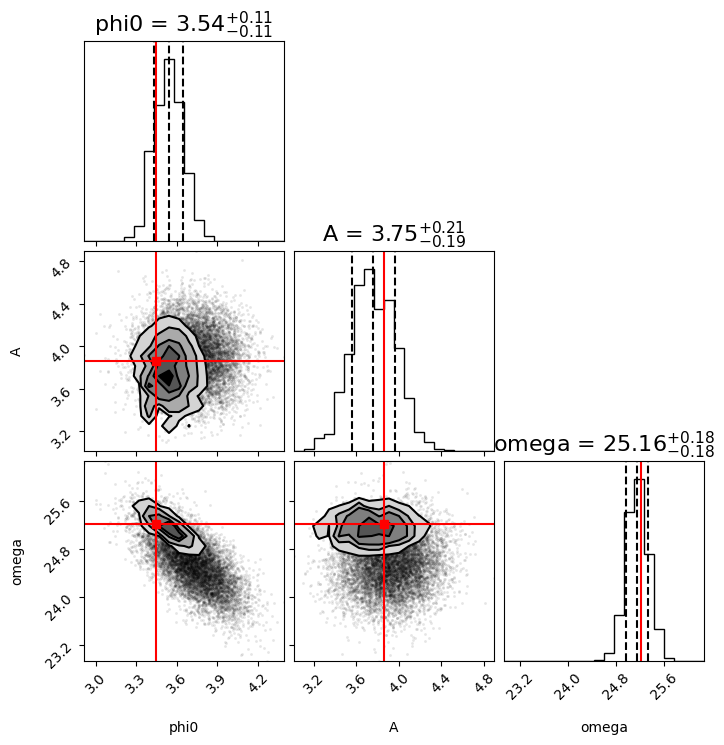

In [32]:
y_pred, weights = engine.predict(x_obs, x_err=np.array([1]*50), y_true=y_true, n_samples=10000, corner_reweight=True)

7% is much lower than SNPE. But the advantage of ANPE is that we can do inference on any observation within the prior:

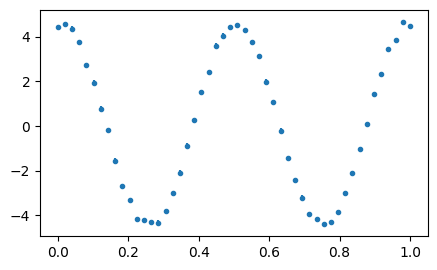

In [33]:
# change random seed to 1 and apply tiny noise only

plt.figure(figsize=(5,3))
np.random.seed(5)

# draw random parameter from prior
y_true = [var.rvs(1)[0] for var in priors]

# add fixed gaussian noise of 0.1
x_err = 0.1
x_obs = sine(y_true) + np.random.normal(size=50) * x_err
plt.errorbar(t, x_obs, yerr=x_err, fmt='.')

plt.show()

Samples outside prior N = 28
Generating simulations


998it [00:01, 563.27it/s]


Effective Sample Size = 5.7
Sampling efficiency = 0.1%


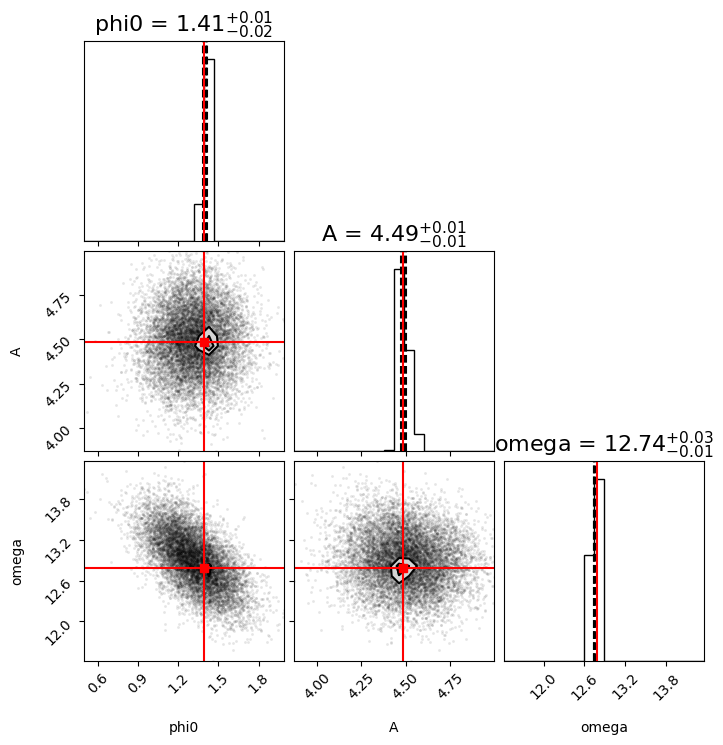

In [36]:
y_pred, weights = engine.predict(x_obs, x_err=np.array([0.1]*50), y_true=y_true, n_samples=10000, corner_reweight=True)

Note that the above is only a demonstration. With a larger network and training set, we may achieve much higher sampling efficiency for ANPE.